In [1]:
def visualize(params,line,res,c):

    cond_probs = np.zeros((len(params.quds), res.size*2))
    for qud_index in range(len(params.quds)):

        subspace_mean,subspace_prior_mean,subspace_variance = params.subspace_means[line][qud_index],params.subspace_prior_means[line][qud_index],params.subspace_variances[line][qud_index]
#         print("prior meannn",subspace_prior_mean)
        vals=scipy.stats.multivariate_normal.pdf((np.arange(-res.size,res.size)*res.amount),mean=subspace_mean,cov=subspace_variance)
        vals/=np.sum(vals)
        cond_probs[qud_index]=vals
        
#         print(scipy.stats.multivariate_normal.pdf([1,2,3],mean=subspace_mean,cov=subspace_variance))
#         print(vals.shape)
#         print(subspace_mean)
#         print("CHECK",np.sum((np.arange(-size,size)*scale+subspace_prior_mean)*vals))

#     print(params.subspace_means.shape)
#     print(params.subspace_means)
#     print("SUBSPACE MEANS",params.subspace_means)
    marginal_mean = np.sum(params.subspace_means[line]*params.qud_marginals)
    print("marginal mean",marginal_mean)
    print("prior mean",subspace_prior_mean)
    marginal = np.sum(cond_probs*np.expand_dims(params.qud_marginals,1),axis=0)
    print("CHECK",np.sum(marginal*(np.arange(-res.size,res.size)*res.amount)))
    hm = matplotlib.pyplot.scatter(c=c,x=(np.arange(-res.size,res.size)*res.amount),y=marginal)
    print("PRIOR MEAN",params.subspace_prior_means[line][0])
    prior_vals = scipy.stats.multivariate_normal.pdf(np.arange(-res.size,res.size)*res.amount,mean=params.subspace_prior_means[line][0],cov=params.l1_sig1)
    prior_vals/=np.sum(prior_vals)
    prior_hm = matplotlib.pyplot.scatter(c='yellow',x=np.arange(-res.size,res.size)*res.amount,y=prior_vals)
    
#     hm_2 = matplotlib.pyplot.scatter(x=(np.arange(-size,size)*scale)+params.subspace_prior_means[line][0],y=marginal)
    return marginal,marginal_mean,params.subspace_prior_means[line][0]
#     return marginal_means[line]*np.exp(params.qud_marginals)

In [ ]:
from __future__ import division
from collections import defaultdict
import scipy
import numpy as np
import pickle
import itertools
from dist_rsa.dbm import *
from dist_rsa.utils.load_data import *
from dist_rsa.utils.helperfunctions import *
from dist_rsa.utils.config import abstract_threshold,concrete_threshold
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf

# vec_size,vec_kind = 25,'glove.twitter.27B.'
vec_size,vec_kind = 300,'glove.6B.'
# freqs = pickle.load(open('dist_rsa/data/google_freqs/freqs','rb'))
nouns,adjs = get_words(with_freqs=False)
vecs = load_vecs(mean=True,pca=False,vec_length=vec_size,vec_type=vec_kind) 

def l1_model(subj,pred):

    print('abstract_threshold',abstract_threshold)
    print('concrete_threshold',concrete_threshold)

    qud_words = [a for a in list(adjs) if adjs[a] < abstract_threshold and a in vecs]

    quds = sorted(qud_words,\
        key=lambda x:scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[pred],vecs[subj]],axis=0)),reverse=False)
        # key=lambda x:freqs[x],reverse=True)

    noun_words = [n for n in nouns if nouns[n] > concrete_threshold and n in vecs]
    possible_utterances = sorted(noun_words,\
        key=lambda x: scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[subj],vecs[subj]],axis=0)),reverse=False)
        # key=lambda x:freqs[x],reverse=True)


    for x in possible_utterances:
        if x not in vecs:
            # print(x,"not in vecs")
            possible_utterances.remove(x)
            # raise Exception("utterance not in vecs")

    quds = sorted(quds[:50])
    possible_utterances = possible_utterances[:200]

    print("QUDS",quds[:10]) 
    print("UTTERANCES:\n",possible_utterances[:10])


    params = Inference_Params(
        vecs=vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=list(set(possible_utterances).union(set([pred]))),
        sig1=20.0,sig2=0.1,l1_sig1=20.0,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=True,
        heatmap=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_mixture",
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)


    out = run.tf_results
    tf.reset_default_graph()
    return out,params

    # world_means = run.world_samples
    # print(world_means[:5],"MEANS")

    # print(results[:5])

    # if not is_baseline:
    #     worldm = run.world_movement("cosine",comparanda=[x for x in qud_words if x in vecs])
    #     # print("\nworld\n",worldm[:5])
    # else: worldm = None
        # out.write("\nWORLD MOVEMENT:\n")
        # out.write(str(worldm))
    # print("WORLD MOVEMENT WITH PROJECTION\n:",run.world_movement("cosine",comparanda=[x for x in quds if x in vecs],do_projection=True)[:50])
    # print("BASELINE:\n",sorted(qud_words,\
    #     key=lambda x:scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[subj],vecs[pred]],axis=0)),reverse=False)[:5])

    # demarg = demarginalize_product_space(results)
    # print("\ndemarginalized:\n,",demarg[:5])
    # out.write("\ndemarginalized:\n")
    # out.write((str(demarg)))

    # params.number_of_qud_dimensions=1
    # run = Dist_RSA_Inference(params)
    # run.compute_l1(load=0,save=False)
    # results2 = run.qud_results()
    # # print("\n1d results\n",results2[:10])
    # one_d = results2
    # one_d=None

if __name__ == "__main__":

    

    # for x in range(1):
    #     l1_model(("father","shark",0.5,0.5,1.0,0,100,False))
    results_dict={}
    for subj,pred in metaphors:
        
    
        results,params = l1_model(subj=subj,pred=pred)
        results_dict[(subj,pred)]=params

        # print()


        # print(l1_model(subj="man",pred="swimmer"))

        # print(scipy.spatial.distance.cosine(vecs['man']-means1[0],vecs['man']-means2[0]))
        # worlds,quds=l1_model(("wall","frog",1.0,1.0,1.0,0,1000,True))
        # print(quds[:10])






loading vecs (load vecs): glove.6B.mean_vecs300
abstract_threshold 2.5
concrete_threshold 3.0
QUDS ['longtime', 'main', 'major', 'founding', 'other', 'alleged', 'responsible', 'particular', 'political', 'important']
UTTERANCES:
 ['principal', 'associate', 'assistant', 'chief', 'teacher', 'key', 'director', 'present', 'example', 'school']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['principal']
predicate dictator
SIGs 1&2: 20.0 0.1
L1 SIG 20.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_mixture RSA with 201 possible utterances and 50
RUNNING DISCRETE MIXTURE MODEL


  0%|          | 0/50 [00:00<?, ?it/s]

qud_combinations 50 [['alleged'], ['beloved'], ['best'], ['brutal'], ['certain'], ['civil'], ['common'], ['corrupt'], ['critical'], ['democratic'], ['different'], ['effective'], ['evil'], ['famous'], ['fascist'], ['foremost'], ['founding'], ['good'], ['great'], ['important'], ['legal'], ['legitimate'], ['likely'], ['longtime'], ['loyal'], ['main'], ['major'], ['national'], ['notorious'], ['original'], ['other'], ['particular'], ['political'], ['popular'], ['possible'], ['primary'], ['prime'], ['prior'], ['prominent'], ['responsible'], ['revolutionary'], ['significant'], ['supposed'], ['supreme'], ['sure'], ['true'], ['tyrannical'], ['unknown'], ['various'], ['vice']]
quds 50
SIZE,AMOUNT 100 0.1
CURRENT QUD: ['alleged']
(2, 2, 4)
(2, 2, 3, 4)


  2%|▏         | 1/50 [00:02<02:21,  2.88s/it]

CURRENT QUD: ['beloved']


  4%|▍         | 2/50 [00:05<02:04,  2.59s/it]

CURRENT QUD: ['best']


  6%|▌         | 3/50 [00:07<01:59,  2.55s/it]

CURRENT QUD: ['brutal']


  8%|▊         | 4/50 [00:10<01:58,  2.59s/it]

CURRENT QUD: ['certain']


 10%|█         | 5/50 [00:13<01:57,  2.62s/it]

CURRENT QUD: ['civil']


 12%|█▏        | 6/50 [00:15<01:57,  2.66s/it]

CURRENT QUD: ['common']


 14%|█▍        | 7/50 [00:18<01:55,  2.69s/it]

CURRENT QUD: ['corrupt']


 16%|█▌        | 8/50 [00:22<01:56,  2.77s/it]

CURRENT QUD: ['critical']


 18%|█▊        | 9/50 [00:25<01:55,  2.82s/it]

CURRENT QUD: ['democratic']


 20%|██        | 10/50 [00:29<01:56,  2.91s/it]

CURRENT QUD: ['different']


 22%|██▏       | 11/50 [00:32<01:55,  2.97s/it]

CURRENT QUD: ['effective']


 24%|██▍       | 12/50 [00:36<01:56,  3.07s/it]

CURRENT QUD: ['evil']


 26%|██▌       | 13/50 [00:40<01:56,  3.14s/it]

CURRENT QUD: ['famous']


 28%|██▊       | 14/50 [00:44<01:55,  3.20s/it]

CURRENT QUD: ['fascist']


 30%|███       | 15/50 [00:49<01:55,  3.30s/it]

CURRENT QUD: ['foremost']


 32%|███▏      | 16/50 [00:53<01:54,  3.36s/it]

CURRENT QUD: ['founding']


 34%|███▍      | 17/50 [00:58<01:53,  3.44s/it]

CURRENT QUD: ['good']


 36%|███▌      | 18/50 [01:03<01:52,  3.51s/it]

CURRENT QUD: ['great']


 38%|███▊      | 19/50 [01:08<01:52,  3.62s/it]

CURRENT QUD: ['important']


 40%|████      | 20/50 [01:13<01:50,  3.70s/it]

CURRENT QUD: ['legal']


 42%|████▏     | 21/50 [01:19<01:49,  3.77s/it]

CURRENT QUD: ['legitimate']


 44%|████▍     | 22/50 [01:24<01:47,  3.85s/it]

CURRENT QUD: ['likely']


 46%|████▌     | 23/50 [01:30<01:45,  3.92s/it]

CURRENT QUD: ['longtime']


 48%|████▊     | 24/50 [01:36<01:44,  4.03s/it]

CURRENT QUD: ['loyal']


 50%|█████     | 25/50 [01:42<01:42,  4.11s/it]

CURRENT QUD: ['main']


 52%|█████▏    | 26/50 [01:48<01:40,  4.19s/it]

CURRENT QUD: ['major']


 54%|█████▍    | 27/50 [01:55<01:38,  4.26s/it]

CURRENT QUD: ['national']


 56%|█████▌    | 28/50 [02:01<01:35,  4.34s/it]

CURRENT QUD: ['notorious']


 58%|█████▊    | 29/50 [02:08<01:32,  4.42s/it]

CURRENT QUD: ['original']


 60%|██████    | 30/50 [02:15<01:30,  4.50s/it]

CURRENT QUD: ['other']


 62%|██████▏   | 31/50 [02:22<01:27,  4.61s/it]

CURRENT QUD: ['particular']


 64%|██████▍   | 32/50 [02:29<01:24,  4.69s/it]

CURRENT QUD: ['political']


 66%|██████▌   | 33/50 [02:37<01:20,  4.76s/it]

CURRENT QUD: ['popular']


 68%|██████▊   | 34/50 [02:44<01:17,  4.84s/it]

CURRENT QUD: ['possible']


 70%|███████   | 35/50 [02:52<01:13,  4.92s/it]

CURRENT QUD: ['primary']


 72%|███████▏  | 36/50 [02:59<01:09,  5.00s/it]

CURRENT QUD: ['prime']


 74%|███████▍  | 37/50 [03:07<01:06,  5.08s/it]

CURRENT QUD: ['prior']


 76%|███████▌  | 38/50 [03:17<01:02,  5.19s/it]

CURRENT QUD: ['prominent']


 78%|███████▊  | 39/50 [03:25<00:57,  5.26s/it]

CURRENT QUD: ['responsible']


 80%|████████  | 40/50 [03:33<00:53,  5.34s/it]

CURRENT QUD: ['revolutionary']


 82%|████████▏ | 41/50 [03:42<00:48,  5.42s/it]

CURRENT QUD: ['significant']


 84%|████████▍ | 42/50 [03:50<00:43,  5.50s/it]

CURRENT QUD: ['supposed']


 86%|████████▌ | 43/50 [03:59<00:39,  5.58s/it]

CURRENT QUD: ['supreme']


 88%|████████▊ | 44/50 [04:08<00:33,  5.66s/it]

CURRENT QUD: ['sure']


 90%|█████████ | 45/50 [04:18<00:28,  5.74s/it]

CURRENT QUD: ['true']


 92%|█████████▏| 46/50 [04:27<00:23,  5.82s/it]

CURRENT QUD: ['tyrannical']


 94%|█████████▍| 47/50 [04:37<00:17,  5.90s/it]

CURRENT QUD: ['unknown']


 96%|█████████▌| 48/50 [04:48<00:12,  6.01s/it]

CURRENT QUD: ['various']


 98%|█████████▊| 49/50 [04:58<00:06,  6.10s/it]

CURRENT QUD: ['vice']


100%|██████████| 50/50 [05:09<00:00,  6.18s/it]


time: 309.19897842407227
time: 34.69797682762146
time: 46.15418553352356
abstract_threshold 2.5
concrete_threshold 3.0
QUDS ['virtual', 'original', 'usual', 'able', 'other', 'claustrophobic', 'available', 'entire', 'comfortable', 'simple']
UTTERANCES:
 ['room', 'rooms', 'floor', 'bedroom', 'dining', 'locker', 'door', 'hallway', 'kitchen', 'bathroom']
RESOLUTION. SIZE: 100 AMOUNT: 0.1


  0%|          | 0/50 [00:00<?, ?it/s]

subject: ['room']
predicate dungeon
SIGs 1&2: 20.0 0.1
L1 SIG 20.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_mixture RSA with 201 possible utterances and 50
RUNNING DISCRETE MIXTURE MODEL
qud_combinations 50 [['able'], ['actual'], ['additional'], ['available'], ['best'], ['certain'], ['claustrophobic'], ['comfortable'], ['complex'], ['creepy'], ['detailed'], ['different'], ['easy'], ['elegant'], ['entire'], ['extra'], ['fashioned'], ['free'], ['good'], ['great'], ['interesting'], ['intimate'], ['main'], ['medieval'], ['modern'], ['mysterious'], ['nice'], ['normal'], ['original'], ['other'], ['particular'], ['perfect'], ['possible'], ['ready'], ['regular'], ['similar'], ['simple'], ['special'], ['strange'], ['supposed'], ['sure'], ['true'], ['typical'], ['unconscious'], ['unfinished'], ['unique'], ['unusual'], ['usual'], ['various'], ['virtual']]
quds 50
SIZE,AMOUNT 100 0.1
CURRENT QUD: ['able']


  2%|▏         | 1/50 [00:01<01:37,  1.98s/it]

CURRENT QUD: ['actual']


  4%|▍         | 2/50 [00:04<01:47,  2.24s/it]

CURRENT QUD: ['additional']


  6%|▌         | 3/50 [00:07<01:53,  2.42s/it]

CURRENT QUD: ['available']


  8%|▊         | 4/50 [00:10<01:56,  2.53s/it]

CURRENT QUD: ['best']


 10%|█         | 5/50 [00:13<01:57,  2.61s/it]

CURRENT QUD: ['certain']


 12%|█▏        | 6/50 [00:16<01:58,  2.70s/it]

CURRENT QUD: ['claustrophobic']


 14%|█▍        | 7/50 [00:19<01:59,  2.77s/it]

CURRENT QUD: ['comfortable']


 16%|█▌        | 8/50 [00:24<02:10,  3.10s/it]

CURRENT QUD: ['complex']


 18%|█▊        | 9/50 [00:28<02:09,  3.16s/it]

CURRENT QUD: ['creepy']


 20%|██        | 10/50 [00:32<02:08,  3.21s/it]

CURRENT QUD: ['detailed']


 22%|██▏       | 11/50 [00:36<02:07,  3.27s/it]

CURRENT QUD: ['different']


 24%|██▍       | 12/50 [00:40<02:06,  3.34s/it]

CURRENT QUD: ['easy']


 26%|██▌       | 13/50 [00:44<02:05,  3.40s/it]

CURRENT QUD: ['elegant']


 28%|██▊       | 14/50 [00:48<02:04,  3.47s/it]

CURRENT QUD: ['entire']


 30%|███       | 15/50 [00:53<02:03,  3.54s/it]

CURRENT QUD: ['extra']


 32%|███▏      | 16/50 [00:57<02:02,  3.61s/it]

CURRENT QUD: ['fashioned']


 34%|███▍      | 17/50 [01:02<02:01,  3.68s/it]

CURRENT QUD: ['free']


 36%|███▌      | 18/50 [01:07<02:00,  3.76s/it]

CURRENT QUD: ['good']


 38%|███▊      | 19/50 [01:12<01:58,  3.83s/it]

CURRENT QUD: ['great']


 40%|████      | 20/50 [01:18<01:57,  3.91s/it]

CURRENT QUD: ['interesting']


 42%|████▏     | 21/50 [01:23<01:55,  3.98s/it]

CURRENT QUD: ['intimate']


 44%|████▍     | 22/50 [01:29<01:53,  4.06s/it]

CURRENT QUD: ['main']


 46%|████▌     | 23/50 [01:37<01:54,  4.25s/it]

CURRENT QUD: ['medieval']


 48%|████▊     | 24/50 [01:43<01:52,  4.32s/it]

CURRENT QUD: ['modern']


 50%|█████     | 25/50 [01:49<01:49,  4.40s/it]

CURRENT QUD: ['mysterious']


 52%|█████▏    | 26/50 [01:56<01:47,  4.47s/it]

CURRENT QUD: ['nice']


 54%|█████▍    | 27/50 [02:02<01:44,  4.55s/it]

CURRENT QUD: ['normal']


 56%|█████▌    | 28/50 [02:09<01:41,  4.63s/it]

CURRENT QUD: ['original']


 58%|█████▊    | 29/50 [02:16<01:38,  4.71s/it]

CURRENT QUD: ['other']


 60%|██████    | 30/50 [02:23<01:35,  4.79s/it]

CURRENT QUD: ['particular']


 62%|██████▏   | 31/50 [02:30<01:32,  4.87s/it]

CURRENT QUD: ['perfect']


 64%|██████▍   | 32/50 [02:38<01:29,  4.95s/it]

CURRENT QUD: ['possible']


 66%|██████▌   | 33/50 [02:45<01:25,  5.03s/it]

CURRENT QUD: ['ready']


 68%|██████▊   | 34/50 [02:53<01:21,  5.11s/it]

CURRENT QUD: ['regular']


 70%|███████   | 35/50 [03:01<01:17,  5.19s/it]

CURRENT QUD: ['similar']


 72%|███████▏  | 36/50 [03:09<01:13,  5.27s/it]

CURRENT QUD: ['simple']


 74%|███████▍  | 37/50 [03:17<01:09,  5.35s/it]

CURRENT QUD: ['special']


 76%|███████▌  | 38/50 [03:26<01:05,  5.43s/it]

CURRENT QUD: ['strange']


 78%|███████▊  | 39/50 [03:35<01:00,  5.52s/it]

CURRENT QUD: ['supposed']


 80%|████████  | 40/50 [03:44<00:56,  5.60s/it]

CURRENT QUD: ['sure']


 82%|████████▏ | 41/50 [03:53<00:51,  5.68s/it]

CURRENT QUD: ['true']


 84%|████████▍ | 42/50 [04:05<00:46,  5.84s/it]

CURRENT QUD: ['typical']


In [5]:
# params = results_dict[("room","dungeon")]

# pickleable_results_dict = []
# for t in results_dict:
#     pickleable_results_dict.append(Pickleable_Params(results_dict[t]))
    
# write a pickler: it takes results_dict and makes a class which pickles
    
class Results_Pickler:
    def __init__(self,results_dict,path):
        self.path=path
        self.results_dict=results_dict
        
    def save(self):    
        for t in self.results_dict:
            pickle.dump(Pickleable_Params(self.results_dict[t]),open(self.path+t[0]+t[1],'wb'))
        
    def retrieve(self,t):
        return pickle.load(open(self.path+t[0]+t[1],'rb'))


class Pickleable_Params:
    def __init__(self,d):
        self.quds=d.quds
        self.qud_marginals=d.qud_marginals
        self.subspace_prior_means=d.subspace_prior_means
        self.subspace_means=d.subspace_means
        self.subspace_variances=d.subspace_variances
        self.l1_sig1=d.l1_sig1


r = Results_Pickler(results_dict=results_dict,path="dist_rsa/data/results/pickles/version50")
r.save()
  
# pickleable_params = Pickleable_Params(params)
# pickleable_results_dict
# pickle.dump( pickleable_results_dict,open("dist_rsa/data/results_dict.pkl","wb"))
# a = pickle.load(open("dist_rsa/data/results_dict.pkl","rb"))
# a.subspace_prior_means


RESOLUTION. SIZE: 50 AMOUNT: 0.1
QUD vice
marginal mean 3.059487813780027
prior mean 3.1335098122623686
CHECK 16.523796155382875
PRIOR MEAN 3.1335098122623686


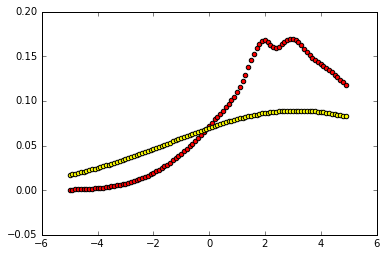

In [96]:
# ps = params
ps = r.retrieve(('principal','dictator'))
res = Resolution(5.0,50)

# qud = sorted(ps.quds).index("effective")
# _,_,_ = visualize(ps,qud,res,'red')
# print("QUD:",ps.quds[qud])
# print(sorted(list(zip(sorted(ps.quds),ps.qud_marginals)),key=lambda x:x[1],reverse=True))

# for i in range(len(ps.quds)):
#     if i > 0: _,_,_ = visualize(params,i,res,'red')
    
qud = 49
print("QUD",sorted(ps.quds)[qud])
_,_,_ = visualize(ps,qud,res,'red')

#PRIOR
# vals = scipy.stats.multivariate_normal.pdf(np.arange(-res.size,res.size)*res.amount,mean=params.subspace_prior_means[line][0],cov=5.0)
# hm = matplotlib.pyplot.scatter(c='yellow',x=np.arange(-res.size,res.size)*res.amount,y=vals)


In [2]:
from __future__ import division
from collections import defaultdict
import scipy
import numpy as np
import pickle
import itertools
from dist_rsa.dbm import *
from dist_rsa.utils.load_data import *
from dist_rsa.utils.helperfunctions import *
from dist_rsa.utils.config import abstract_threshold,concrete_threshold
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from dist_rsa.utils.simple_vecs import real_vecs as simple_vecs
import itertools
from dist_rsa.dbm import Resolution




def l1_model(subj,pred,sig1,sig2,l1_sig1,quds,possible_utterances):
    vec_size,vec_kind = 25,'glove.twitter.27B.'

    vecs = simple_vecs
    real_vecs= simple_vecs

    print("UTTERANCES:\n",sorted(list(set(possible_utterances).union(set([pred]))))[:20])

    params = Inference_Params(
        vecs=real_vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=sorted(list(set(possible_utterances).union(set([pred])))),
        sig1=sig1,sig2=sig2, l1_sig1=l1_sig1,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_mixture",
        heatmap=True
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)
    tf_results = run.tf_results
    return tf_results,params

if __name__ == "__main__":

    results,params = l1_model(subj="man",pred="swimmer",sig1=5.0,sig2=0.5,l1_sig1=5.0,quds=["vicious","swims"],possible_utterances=["shark","swimmer","man"])


/home/rcohngordon/dist-rsa/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


UTTERANCES:
 ['man', 'shark', 'swimmer']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['man']
predicate swimmer
SIGs 1&2: 5.0 0.5
L1 SIG 5.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_mixture RSA with 3 possible utterances and 2
RUNNING DISCRETE MIXTURE MODEL


  0%|          | 0/2 [00:00<?, ?it/s]

qud_combinations 2 [['swims'], ['vicious']]
quds 2
SIZE,AMOUNT 100 0.1
CURRENT QUD: ['swims']


 50%|█████     | 1/2 [00:02<00:02,  2.61s/it]

(2, 2, 4)
(2, 2, 3, 4)
CURRENT QUD: ['vicious']


100%|██████████| 2/2 [00:04<00:00,  2.42s/it]


time: 4.853307008743286
time: 1.0020818710327148
HEATMAP MEAN [-0.7863828   0.82393354]
time: 9.9222571849823


-0.8239134019588563
-0.7863797414146605


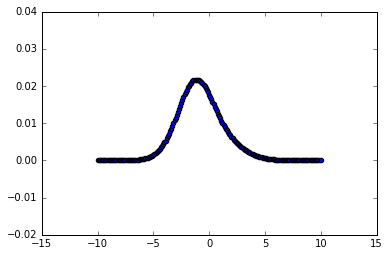

In [11]:
hm_vals = results[0]
# *np.expand_dims(params.qud_marginals,1)
# y=np.sum(hm_vals,axis=1)
# x=(np.arange(-params.resolution.size,params.resolution.size)*params.resolution.amount)
# print(x.shape,y.shape)
hm = matplotlib.pyplot.scatter(c='blue',x=(np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount),y=np.sum(hm_vals,axis=0))
# print((hm_vals))
y = np.sum(hm_vals,axis=1)
print(np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*y))
x = np.sum(hm_vals,axis=0)
print(np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*x))

marginal mean -0.7863801482170345
prior mean 0.0
CHECK -0.7863801273378712
PRIOR MEAN 0.0


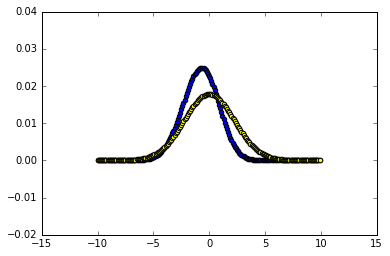

In [12]:
res = params.resolution
# _,_,_ = visualize(params,0,res,'blue')
_,_,_ = visualize(params,1,res,'blue')



#PRIOR
# vals = scipy.stats.multivariate_normal.pdf(np.arange(-res.size,res.size)*res.amount,mean=params.subspace_prior_means[0][0],cov=5.0)
# hm = matplotlib.pyplot.scatter(c='yellow',x=np.arange(-res.size,res.size)*res.amount,y=vals)


In [13]:
from __future__ import division
from collections import defaultdict
import scipy
import numpy as np
import pickle
import itertools
from dist_rsa.dbm import *
from dist_rsa.utils.load_data import *
from dist_rsa.utils.helperfunctions import *
from dist_rsa.utils.config import abstract_threshold,concrete_threshold
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from dist_rsa.utils.simple_vecs import real_vecs as simple_vecs
import itertools
from dist_rsa.dbm import Resolution




def l1_model(subj,pred,sig1,sig2,l1_sig1,quds,possible_utterances):
    vec_size,vec_kind = 25,'glove.twitter.27B.'

    vecs = simple_vecs
    real_vecs= simple_vecs

    print("UTTERANCES:\n",sorted(list(set(possible_utterances).union(set([pred]))))[:20])

    params = Inference_Params(
        vecs=real_vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=sorted(list(set(possible_utterances).union(set([pred])))),
        sig1=sig1,sig2=sig2, l1_sig1=l1_sig1,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_exact",
        heatmap=True
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)
    tf_results = run.tf_results
    return tf_results,params

if __name__ == "__main__":

    results,params = l1_model(subj="man",pred="swimmer",sig1=5.0,sig2=0.5,l1_sig1=5.0,quds=["vicious","swims"],possible_utterances=["shark","swimmer","man"])


UTTERANCES:
 ['man', 'shark', 'swimmer']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['man']
predicate swimmer
SIGs 1&2: 5.0 0.5
L1 SIG 5.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_exact RSA with 3 possible utterances and 2
RUNNING DISCRETE EXACT MODEL
QUDS: [['swims'], ['vicious']]
sum should be unit 1.0000002
MEAN [-1.7340168  1.7477133]


-1.7476779620395975
-1.7339960924058686


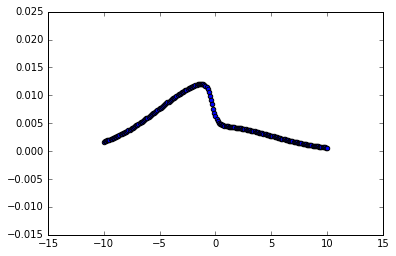

In [15]:
hm_vals = results[0]
# *np.expand_dims(params.qud_marginals,1)
# y=np.sum(hm_vals,axis=1)
# x=(np.arange(-params.resolution.size,params.resolution.size)*params.resolution.amount)
# print(x.shape,y.shape)
hm = matplotlib.pyplot.scatter(c='blue',x=(np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount),y=np.sum(hm_vals,axis=1))
# print((hm_vals))
y = np.sum(hm_vals,axis=1)
print(np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*y))
x = np.sum(hm_vals,axis=0)
print(np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*x))